# NLP Seminar 1 - Normalization and Simple Word Embeddings

In this first NLP seminar, we focus on classical text normalization methods (stemming, lemmatization) and simple word embedding/vectorization techniques (bag of words, TF-IDF), that will allow us to train machine learning methods on text data. 

We use the `nltk` (natural language toolkit) python package, as well as the machine learning framework `scikit-learn`.
If you want to learn more about the popular `nltk` module, refer to the [official website](https://www.nltk.org/) ([API reference](https://www.nltk.org/api/nltk.html), [installation guide](https://www.nltk.org/install.html)).

# 0. Preliminaries

In [1]:
# Module imports
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearnex import patch_sklearn
patch_sklearn(verbose=False)

In [ ]:
#!pip install nltk

In [2]:
# First download some nltk resources
# (By default '!pip install nltk' does not actually download every resource in the module,
# as for example some language models are heavy.)
# The following commands should download every resource needed for this practical:
nltk.download('popular', quiet=True)
nltk.download('universal_tagset', quiet=True)

True

# 1. Download the data


We will work with the famous `20newsgroups` dataset. It consists of a large collection of news posts across 20 topics. We will be using it to test some basic NLP techniques and train a multi-class classification model to predict the most likely topic for unseen news posts. 
For more information, check [the dataset description](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset) and the [import function helper](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

To make the task a bit harder, we import the data without the headers, footers and quotes.

We also restrict the dataset to only 4 of the categories, for presentation simplicity.

In [3]:
from sklearn.datasets import fetch_20newsgroups
# we restrict the data to the following response categories:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

data_train = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42,
                                remove=("headers", "footers", "quotes"))

data_test = fetch_20newsgroups(subset="test", categories=categories, shuffle=True, random_state=42,
                               remove=("headers", "footers", "quotes"))

df_train = pd.DataFrame({"text": data_train.data, "class": data_train.target})
df_test = pd.DataFrame({"text": data_test.data, "class": data_test.target})

In [8]:
# Inspect the data
df_train.head()

,text,class
0,Does anyone know of a good way (standard PC ap...,1
1,"Hi,\n\n\tI have a problem, I hope some of the ...",1
2,"(Well, I'll email also, but this may apply to ...",3
3,"Hello,\n\nI'm writing a paper on the role of t...",3
4,,3


In [9]:
# How many classes are there to identify?
df_train["class"].unique().shape

(4,)

In [10]:
# What do these class labels correspond to?
target_names = data_train.target_names
print(target_names)

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


In [11]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (2257, 2)
Test: (1502, 2)


# 2. Natural Language Processing: Text Normalization

For classic NLP techniques, text normalization can be crucial to good model performance. Their main aim is to decrease the vocabulary size, by reducing similar words to common roots or removing useless words. These techniques include word tokenization, stopword removal, lemmatization, and more. We'll try a few of those here to see their impact on our news classification model.

We begin by testing those text normalization methods on a single news post example, before applying them to the entire dataset.

In [12]:
# Take an example entry in the training set for demonstration purposes here
text = df_train["text"].iloc[11]
print(text)

Hi:

I am digitizing a NTSC signal and displaying on a PC video monitor.
It is known that the display response of tubes is non-linear and is
sometimes said to follow Gamma-Law. I am not certain if these
non-linearities are "Gamma-corrected" before encoding NTSC signals
or if the TV display is supposed to correct this.
 
Also, if  256 grey levels, for example, are coded in a C program do
these intensity levels appear with linear brightness on a PC
monitor? In other words does PC monitor display circuitry
correct for "gamma errrors"?
 
Your response is much appreciated.
 
Amjad.


### 2.1. Tokenization
Before any type of normalization, the first step is to tokenize each document in our corpus. We again rely on the NLTK tokenizer to convert a string to a list of words. We here tokenize the selected `text` observation from above.

In [13]:
text_tokens = nltk.word_tokenize(text)
print(text_tokens)

['Hi', ':', 'I', 'am', 'digitizing', 'a', 'NTSC', 'signal', 'and', 'displaying', 'on', 'a', 'PC', 'video', 'monitor', '.', 'It', 'is', 'known', 'that', 'the', 'display', 'response', 'of', 'tubes', 'is', 'non-linear', 'and', 'is', 'sometimes', 'said', 'to', 'follow', 'Gamma-Law', '.', 'I', 'am', 'not', 'certain', 'if', 'these', 'non-linearities', 'are', '``', 'Gamma-corrected', "''", 'before', 'encoding', 'NTSC', 'signals', 'or', 'if', 'the', 'TV', 'display', 'is', 'supposed', 'to', 'correct', 'this', '.', 'Also', ',', 'if', '256', 'grey', 'levels', ',', 'for', 'example', ',', 'are', 'coded', 'in', 'a', 'C', 'program', 'do', 'these', 'intensity', 'levels', 'appear', 'with', 'linear', 'brightness', 'on', 'a', 'PC', 'monitor', '?', 'In', 'other', 'words', 'does', 'PC', 'monitor', 'display', 'circuitry', 'correct', 'for', '``', 'gamma', 'errrors', "''", '?', 'Your', 'response', 'is', 'much', 'appreciated', '.', 'Amjad', '.']


### 2.2. Stopwords and punctuation

Stopwords correspond to unimportant words which might safely be ignored for the task at hand. For the specific task of news classification, we might for example rely on the default stopwords provided by NLTK.

In [14]:
# Let's use the nltk stopwords available for the English language
stopwords = nltk.corpus.stopwords.words("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

One might also want to remove punctuation tokens. Here is a list of standard punctuation.

In [15]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### 2.3. Stemming

When it comes to reducing similar words to common roots, stemming is the simplest and fastest approach. Stemming is an abstract rule-based process that stems or removes some of the last few characters from a word. This sometimes leads to incorrect meanings and spelling, as a downsize.

Let's try two different stemmers: "PorterStemmer" and the slightly more recent "SnowballStemmer"

In [16]:
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [18]:
ps.stem?

Signature: ps.stem(word, to_lowercase=True)
Docstring: :param to_lowercase: if `to_lowercase=True` the word always lowercase
File:      c:\users\pascheo\appdata\local\programs\python\python312\lib\site-packages\nltk\stem\porter.py
Type:      method

In [19]:
ps = PorterStemmer()
text_stems = [ps.stem(word) for word in text_tokens]
print(text_stems)

['hi', ':', 'i', 'am', 'digit', 'a', 'ntsc', 'signal', 'and', 'display', 'on', 'a', 'pc', 'video', 'monitor', '.', 'it', 'is', 'known', 'that', 'the', 'display', 'respons', 'of', 'tube', 'is', 'non-linear', 'and', 'is', 'sometim', 'said', 'to', 'follow', 'gamma-law', '.', 'i', 'am', 'not', 'certain', 'if', 'these', 'non-linear', 'are', '``', 'gamma-correct', "''", 'befor', 'encod', 'ntsc', 'signal', 'or', 'if', 'the', 'tv', 'display', 'is', 'suppos', 'to', 'correct', 'thi', '.', 'also', ',', 'if', '256', 'grey', 'level', ',', 'for', 'exampl', ',', 'are', 'code', 'in', 'a', 'c', 'program', 'do', 'these', 'intens', 'level', 'appear', 'with', 'linear', 'bright', 'on', 'a', 'pc', 'monitor', '?', 'in', 'other', 'word', 'doe', 'pc', 'monitor', 'display', 'circuitri', 'correct', 'for', '``', 'gamma', 'errror', "''", '?', 'your', 'respons', 'is', 'much', 'appreci', '.', 'amjad', '.']


In [20]:
snowstem = SnowballStemmer("english")
text_sstems = [snowstem.stem(word) for word in text_tokens]
print(text_sstems)

['hi', ':', 'i', 'am', 'digit', 'a', 'ntsc', 'signal', 'and', 'display', 'on', 'a', 'pc', 'video', 'monitor', '.', 'it', 'is', 'known', 'that', 'the', 'display', 'respons', 'of', 'tube', 'is', 'non-linear', 'and', 'is', 'sometim', 'said', 'to', 'follow', 'gamma-law', '.', 'i', 'am', 'not', 'certain', 'if', 'these', 'non-linear', 'are', '``', 'gamma-correct', "''", 'befor', 'encod', 'ntsc', 'signal', 'or', 'if', 'the', 'tv', 'display', 'is', 'suppos', 'to', 'correct', 'this', '.', 'also', ',', 'if', '256', 'grey', 'level', ',', 'for', 'exampl', ',', 'are', 'code', 'in', 'a', 'c', 'program', 'do', 'these', 'intens', 'level', 'appear', 'with', 'linear', 'bright', 'on', 'a', 'pc', 'monitor', '?', 'in', 'other', 'word', 'doe', 'pc', 'monitor', 'display', 'circuitri', 'correct', 'for', '``', 'gamma', 'errror', "''", '?', 'your', 'respons', 'is', 'much', 'appreci', '.', 'amjad', '.']


In [21]:
for w, s in zip(text_tokens, text_sstems):
    print(w, ' => ', s)

Hi  =>  hi
:  =>  :
I  =>  i
am  =>  am
digitizing  =>  digit
a  =>  a
NTSC  =>  ntsc
signal  =>  signal
and  =>  and
displaying  =>  display
on  =>  on
a  =>  a
PC  =>  pc
video  =>  video
monitor  =>  monitor
.  =>  .
It  =>  it
is  =>  is
known  =>  known
that  =>  that
the  =>  the
display  =>  display
response  =>  respons
of  =>  of
tubes  =>  tube
is  =>  is
non-linear  =>  non-linear
and  =>  and
is  =>  is
sometimes  =>  sometim
said  =>  said
to  =>  to
follow  =>  follow
Gamma-Law  =>  gamma-law
.  =>  .
I  =>  i
am  =>  am
not  =>  not
certain  =>  certain
if  =>  if
these  =>  these
non-linearities  =>  non-linear
are  =>  are
``  =>  ``
Gamma-corrected  =>  gamma-correct
''  =>  ''
before  =>  befor
encoding  =>  encod
NTSC  =>  ntsc
signals  =>  signal
or  =>  or
if  =>  if
the  =>  the
TV  =>  tv
display  =>  display
is  =>  is
supposed  =>  suppos
to  =>  to
correct  =>  correct
this  =>  this
.  =>  .
Also  =>  also
,  =>  ,
if  =>  if
256  =>  256
grey  =>  grey
leve

In [22]:
[(a,b) for a, b in zip(text_stems, text_sstems) if a!=b]

[('thi', 'this')]

### 2.4. Part-of-speech (POS) tagging
Part-of-speech tagging categorizes words as a particular part-of-speech (e.g. verb, noun, etc ...) using the word itself and the surrounding context in a predictive model. Those tags can be useful for several types of analyses. In particular, they are used for lemmatization.

Different more or less precise tagsets exist for each language.

In [24]:
# We can use the default pos-tagger provided by NLTK
text_PoS_p = nltk.pos_tag(text_tokens)
print(text_PoS_p)

[('Hi', 'NN'), (':', ':'), ('I', 'PRP'), ('am', 'VBP'), ('digitizing', 'VBG'), ('a', 'DT'), ('NTSC', 'NNP'), ('signal', 'NN'), ('and', 'CC'), ('displaying', 'VBG'), ('on', 'IN'), ('a', 'DT'), ('PC', 'NN'), ('video', 'NN'), ('monitor', 'NN'), ('.', '.'), ('It', 'PRP'), ('is', 'VBZ'), ('known', 'VBN'), ('that', 'IN'), ('the', 'DT'), ('display', 'NN'), ('response', 'NN'), ('of', 'IN'), ('tubes', 'NNS'), ('is', 'VBZ'), ('non-linear', 'JJ'), ('and', 'CC'), ('is', 'VBZ'), ('sometimes', 'RB'), ('said', 'VBD'), ('to', 'TO'), ('follow', 'VB'), ('Gamma-Law', 'NNP'), ('.', '.'), ('I', 'PRP'), ('am', 'VBP'), ('not', 'RB'), ('certain', 'JJ'), ('if', 'IN'), ('these', 'DT'), ('non-linearities', 'NNS'), ('are', 'VBP'), ('``', '``'), ('Gamma-corrected', 'JJ'), ("''", "''"), ('before', 'IN'), ('encoding', 'VBG'), ('NTSC', 'NNP'), ('signals', 'NNS'), ('or', 'CC'), ('if', 'IN'), ('the', 'DT'), ('TV', 'NN'), ('display', 'NN'), ('is', 'VBZ'), ('supposed', 'VBN'), ('to', 'TO'), ('correct', 'VB'), ('this', 'D

https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [25]:
# Or the "universal" tags
text_PoS_u = nltk.pos_tag(text_tokens, tagset="universal")
print(text_PoS_u)

[('Hi', 'NOUN'), (':', '.'), ('I', 'PRON'), ('am', 'VERB'), ('digitizing', 'VERB'), ('a', 'DET'), ('NTSC', 'NOUN'), ('signal', 'NOUN'), ('and', 'CONJ'), ('displaying', 'VERB'), ('on', 'ADP'), ('a', 'DET'), ('PC', 'NOUN'), ('video', 'NOUN'), ('monitor', 'NOUN'), ('.', '.'), ('It', 'PRON'), ('is', 'VERB'), ('known', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('display', 'NOUN'), ('response', 'NOUN'), ('of', 'ADP'), ('tubes', 'NOUN'), ('is', 'VERB'), ('non-linear', 'ADJ'), ('and', 'CONJ'), ('is', 'VERB'), ('sometimes', 'ADV'), ('said', 'VERB'), ('to', 'PRT'), ('follow', 'VERB'), ('Gamma-Law', 'NOUN'), ('.', '.'), ('I', 'PRON'), ('am', 'VERB'), ('not', 'ADV'), ('certain', 'ADJ'), ('if', 'ADP'), ('these', 'DET'), ('non-linearities', 'NOUN'), ('are', 'VERB'), ('``', '.'), ('Gamma-corrected', 'ADJ'), ("''", '.'), ('before', 'ADP'), ('encoding', 'VERB'), ('NTSC', 'NOUN'), ('signals', 'NOUN'), ('or', 'CONJ'), ('if', 'ADP'), ('the', 'DET'), ('TV', 'NOUN'), ('display', 'NOUN'), ('is', 'VERB'), ('s

http://www.lrec-conf.org/proceedings/lrec2012/pdf/274_Paper.pdf

https://github.com/slavpetrov/universal-pos-tags

- VERB - verbs (all tenses and modes)
- NOUN - nouns (common and proper)
- PRON - pronouns 
- ADJ - adjectives
- ADV - adverbs
- ADP - adpositions (prepositions and postpositions)
- CONJ - conjunctions
- DET - determiners
- NUM - cardinal numbers
- PRT - particles or other function words
- X - other: foreign words, typos, abbreviations
- . - punctuation

### 2.5. Lemmatization
Lemmatization considers the context and converts the word to its meaningful base form, which is called the "Lemma".
It uses language-specific lookup tables to find the root forms of words. This makes it more computationnaly expensive than stemming.
We here use the `WordNetLemmatizer` (https://www.nltk.org/api/nltk.stem.wordnet.html).
It uses the Wordnet database (https://wordnet.princeton.edu/) to find the lemma of a word, given the word AND its PoS tag!

In [26]:
# We can use the English language lemmatizer provided by NLTK
wnl = nltk.stem.WordNetLemmatizer()

In [27]:
?wnl.lemmatize

Signature: wnl.lemmatize(word: str, pos: str = 'n') -> str
Docstring:
Lemmatize `word` using WordNet's built-in morphy function.
Returns the input word unchanged if it cannot be found in WordNet.

:param word: The input word to lemmatize.
:type word: str
:param pos: The Part Of Speech tag. Valid options are `"n"` for nouns,
    `"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"`
    for satellite adjectives.
:param pos: str
:return: The lemma of `word`, for the given `pos`.
File:      c:\users\pascheo\appdata\local\programs\python\python312\lib\site-packages\nltk\stem\wordnet.py
Type:      method

In [28]:
for w, pos in text_PoS_u:
    # Map the detailed set of POS-tags to nouns/verbs for the lemmatizer
    if pos in ["VERB"]:
        pos = 'v'
    elif pos in ["ADJ"]:
        pos = 'a'
    elif pos in ["ADV"]:
        pos = 'r'
    elif pos in ["NOUN"]:
        pos = 'n'
    else:
        pos = 'n'
    # print the original tokens and their lemma
    print(f"{w} -> {wnl.lemmatize(w, pos=pos)}")

Hi -> Hi
: -> :
I -> I
am -> be
digitizing -> digitize
a -> a
NTSC -> NTSC
signal -> signal
and -> and
displaying -> display
on -> on
a -> a
PC -> PC
video -> video
monitor -> monitor
. -> .
It -> It
is -> be
known -> know
that -> that
the -> the
display -> display
response -> response
of -> of
tubes -> tube
is -> be
non-linear -> non-linear
and -> and
is -> be
sometimes -> sometimes
said -> say
to -> to
follow -> follow
Gamma-Law -> Gamma-Law
. -> .
I -> I
am -> be
not -> not
certain -> certain
if -> if
these -> these
non-linearities -> non-linearities
are -> be
`` -> ``
Gamma-corrected -> Gamma-corrected
'' -> ''
before -> before
encoding -> encode
NTSC -> NTSC
signals -> signal
or -> or
if -> if
the -> the
TV -> TV
display -> display
is -> be
supposed -> suppose
to -> to
correct -> correct
this -> this
. -> .
Also -> Also
, -> ,
if -> if
256 -> 256
grey -> grey
levels -> level
, -> ,
for -> for
example -> example
, -> ,
are -> be
coded -> cod
in -> in
a -> a
C -> C
program -> progra

In [29]:
# To illustrate the difference:
diff_ex = ["run","ran",
           "universal", "university", "universe",
           "alumnus","alumni"]

for w, pos in nltk.pos_tag(diff_ex, tagset="universal"):
    # Map the detailed set of POS-tags to nouns/verbs for the lemmatizer
    if pos in ["VERB"]:
        pos = "v"
    elif pos in ["ADJ"]:
        pos = "a"
    elif pos in ["ADV"]:
        pos = "r"
    elif pos in ["NOUN"]:
        pos = "n"
    else:
        pos = "n"
    print(f"{w} - stem: {ps.stem(w)} - lemma: {wnl.lemmatize(w, pos=pos)}")

run - stem: run - lemma: run
ran - stem: ran - lemma: run
universal - stem: univers - lemma: universal
university - stem: univers - lemma: university
universe - stem: univers - lemma: universe
alumnus - stem: alumnu - lemma: alumnus
alumni - stem: alumni - lemma: alumnus


### 2.6. Putting it all together

Let's combine all of the above techniques into a single "tokenize + normalize" function which will output a list of normalized words given a string of text (document) as input.

In [30]:
# Write your custom tokenizer method here:
def custom_tokenizer(text: str):
    text_tokens = nltk.word_tokenize(text)
    output = []
    for w, pos in nltk.pos_tag(text_tokens, tagset="universal"):
        if pos in ["VERB"]:
            pos = "v"
        elif pos in ["ADJ"]:
            pos = "a"
        elif pos in ["ADV"]:
            pos = "r"
        elif pos in ["NOUN"]:
            pos = "n"
        else:
            pos = "n"

        # Lemmatized form accounting for POS-tag
        l = wnl.lemmatize(w, pos=pos)

        # Filter out stopwords
        if l not in stopwords:
            output.append(l)

    return output

In [31]:
# Try it out on the text
print(custom_tokenizer(text))

['Hi', ':', 'I', 'digitize', 'NTSC', 'signal', 'display', 'PC', 'video', 'monitor', '.', 'It', 'know', 'display', 'response', 'tube', 'non-linear', 'sometimes', 'say', 'follow', 'Gamma-Law', '.', 'I', 'certain', 'non-linearities', '``', 'Gamma-corrected', "''", 'encode', 'NTSC', 'signal', 'TV', 'display', 'suppose', 'correct', '.', 'Also', ',', '256', 'grey', 'level', ',', 'example', ',', 'cod', 'C', 'program', 'intensity', 'level', 'appear', 'linear', 'brightness', 'PC', 'monitor', '?', 'In', 'word', 'PC', 'monitor', 'display', 'circuitry', 'correct', '``', 'gamma', 'errrors', "''", '?', 'Your', 'response', 'much', 'appreciate', '.', 'Amjad', '.']


# 3. Word embeddings and text classification

Using the NLP normalization techniques from above, including our custom tokenization method, we want to train a simple multi-class ML classifier to predict the news topic. In order to do so, we must first vectorize the text data.

### 3.1. Bag-of-words (BOW)

Bag-of-words is the simplest *embedding* technique in which words are represented as one-hot encoded numeric vectors of word counts. The length of these vectors corresponds to the size of the (reduced) vocabulary of the training corpus.
That is, each column $j$ in the resulting sparse matrix represents a word and and each row $i$ represents a different observation (i.e. document), and the coresonping entry in the matrix is the word count of how many times the word $j$ appears in document $i$.
See [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for the scikit-learn implementation of the bag-of-words embedding and its many options.

We start by training the bag-of-words on our train corpus, and compare the vocabulary size with and without our `'custom_tokenizer'` normalization procedure. We can ignore tokens that appear in less than 0.1% of documents.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
simple_vectorizer = CountVectorizer(lowercase=True, min_df=1e-3)

bow_train_simple = simple_vectorizer.fit_transform(df_train['text'])

In [36]:
bow_train_simple[11, 285]

0

In [37]:
bow_train_simple.shape

(2257, 9187)

In [38]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, lowercase=True, min_df=1e-3)

bow_train = vectorizer.fit_transform(df_train["text"])

c:\Users\pascheo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
bow_train.shape

(2257, 7245)

### 3.2. Bag-of-words (BOW) with Term-frequency Inverse-document-frequency (TF-IDF)

TF-IDF uses the **same** one-hot encoding as traditional BOW, but transforms the simple counts to the relative word frequency, normalized by the inverse-document-frequency to account for frequently occurring words across all documents. 

The intuition is that not only the word's frequency in a given document indicates if that word represents the document well, but also how rare it is in other documents in comparison.

We now compute the TF-IDF transformation of the BoW, using our `'custom_tokenizer'`. See the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) scikit-learn classes for help.

#### Way 1: two-step bag of words and TF-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

#using the BoW from above:
tfidf_train0 = tfidf_transformer.fit_transform(bow_train)

In [41]:
tfidf_train0.shape

(2257, 7245)

#### Way 2: both at once

Here we repeat the two steps above in a single equivalent step, using TfidfVectorizer.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=True, min_df=1e-3)

tfidf_train = tfidf_vectorizer.fit_transform(df_train["text"])

In [43]:
tfidf_train.shape

(2257, 7245)

# 4. Topic Classification using Simple Machine Learning

### 4.1. Lemmatization and TF-IDF impacts

In this section we want to study the impact of lemmatization and of TF-IDF on the classification accuracy of a simple ML model. We use a multi-class logistic regression with arbitrary hyper-parameter `C=10`. Choose the `'liblinear'` solver, that seems more efficient for this task.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Let's check the test accuracy using BoW without lemmatization.

In [45]:
clf = LogisticRegression(C=10, max_iter=int(1e4), solver='liblinear')
clf.fit(bow_train_simple, df_train["class"])

# Run the inference on test data
pred_bow_simple = clf.predict(simple_vectorizer.transform(df_test['text']))

In [51]:
pred_bow_simple

array([2, 2, 2, ..., 2, 1, 2], dtype=int64)

In [46]:
# Report the score
accuracy_score(df_test["class"], pred_bow_simple)

0.7543275632490013

Is the lemmatization improving the test accuracy?

In [47]:
clf = LogisticRegression(C=10, max_iter=int(1e4), solver='liblinear')
clf.fit(bow_train, df_train["class"])

# Run the inference on test data
pred_bow = clf.predict(vectorizer.transform(df_test["text"]))

In [48]:
# Report the score
accuracy_score(df_test["class"], pred_bow)

0.7609853528628495

Let's see if using TF-IDF weights improves the score further.

In [49]:
clf = LogisticRegression(C=10, max_iter=int(1e4), solver='liblinear')
clf.fit(tfidf_train, df_train["class"])

# Run the inference on test data
pred_tfidf = clf.predict(tfidf_vectorizer.transform(df_test["text"]))

In [50]:
# Report the score
accuracy_score(df_test["class"], pred_tfidf)

0.8142476697736352

This already performs better than a simple BOW model. You can try changing the vectorizer parameters or using a different ML model for the classification. We will investigate more advanced methods in later labs.

### 4.2. Hyper-Parameter Tuning

We can perform a cross-validated grid search to select the best hyper-parameter values for both the TF-IDF vectorizer and the logistic regression model at the same time using a sklearn `Pipeline`. For the TF-IDF Vectorizer, let's for example check if considering bigrams in the vocabulary helps the classifier. For the logistic regression, the tuning parameter is the cost ($1/penalty$) `'C'`. (Non exhaustive; there are other parameters of the vectorizer that might be worth fine-tuning, for example.)

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV

In [53]:
logistic_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=True, min_df=1e-3, max_df=0.999)),
    ("logistic", LogisticRegression(max_iter=int(1e4), solver='liblinear'))
])

In [54]:
# Define parameter grid
my_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    "logistic__C": [10, 100, 1000],
}

# Define folds
folds = KFold(n_splits=3, shuffle=True, random_state=42)

# Define grid search CV
tfidf_logistic_cv = GridSearchCV(estimator=logistic_pipe, param_grid=my_grid, scoring="accuracy", cv=folds, n_jobs=-2)

# Run CV
tfidf_logistic_cv.fit(df_train["text"], df_train["class"])

c:\Users\pascheo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.999,
                                                        min_df=0.001,
                                                        tokenizer=<function custom_tokenizer at 0x0000017820CBE8E0>)),
                                       ('logistic',
                                        LogisticRegression(max_iter=10000,
                                                           solver='liblinear'))]),
             n_jobs=-2,
             param_grid={'logistic__C': [10, 100, 1000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [55]:
pd.DataFrame(tfidf_logistic_cv.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,57.351774,2.316200,27.138804,1.591439,100,"(1, 1)","{'logistic__C': 100, 'tfidf__ngram_range': (1,...",0.865870,0.856383,0.849734,0.857329,0.006621,1
0,59.252815,1.169756,26.600270,1.398977,10,"(1, 1)","{'logistic__C': 10, 'tfidf__ngram_range': (1, 1)}",0.860558,0.855053,0.849734,0.855115,0.004419,2
4,51.027065,8.774330,24.393622,2.415803,1000,"(1, 1)","{'logistic__C': 1000, 'tfidf__ngram_range': (1...",0.863214,0.853723,0.848404,0.855114,0.006125,3
3,57.391230,1.343016,27.579280,1.590531,100,"(1, 2)","{'logistic__C': 100, 'tfidf__ngram_range': (1,...",0.873838,0.847074,0.844415,0.855109,0.013288,4
5,40.315226,1.276512,19.973257,0.910242,1000,"(1, 2)","{'logistic__C': 1000, 'tfidf__ngram_range': (1...",0.860558,0.848404,0.847074,0.852012,0.006067,5
1,60.103806,1.046978,26.910979,1.337986,10,"(1, 2)","{'logistic__C': 10, 'tfidf__ngram_range': (1, 2)}",0.864542,0.848404,0.836436,0.849794,0.011516,6


In [56]:
tfidf_logistic_cv.best_params_

{'logistic__C': 100, 'tfidf__ngram_range': (1, 1)}

In [57]:
best_model = tfidf_logistic_cv.best_estimator_
y_hat = best_model.predict(df_test["text"])
accuracy_score(df_test["class"], y_hat)

0.8095872170439414

### 4.3. Diagnostics

We can run some classification accuracy diagnostics to understand in more detail how our model is performing.

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

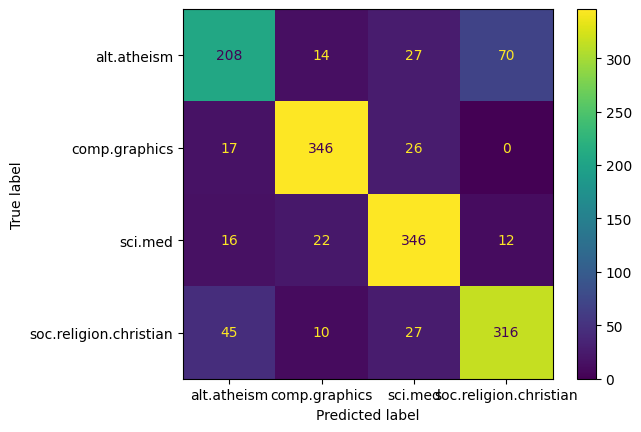

In [59]:
cm = confusion_matrix(df_test["class"], y_hat)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_test.target_names).plot()
plt.show()

rows = actual category

columns = predicted category

In [60]:
print(classification_report(df_test["class"], y_hat, target_names=data_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.73      0.65      0.69       319
         comp.graphics       0.88      0.89      0.89       389
               sci.med       0.81      0.87      0.84       396
soc.religion.christian       0.79      0.79      0.79       398

              accuracy                           0.81      1502
             macro avg       0.80      0.80      0.80      1502
          weighted avg       0.81      0.81      0.81      1502



precision = $TP/(TP+FP)$ = When the model is predicting this class, how often it is right

recall = $TP/(TP+FN)$ = How well the model is performing (accuracy) within each (true) class

F1 = harmonic mean of precision and recall = $\frac{2}{(1/precision)+(1/recall)}$ (1= best, prefect precision and recall, 0=worst, either precision or recall is zero)

support = number of occurences in the test set

Predict the topic of a few sentences:

In [61]:
docs_new = ['Lungs and heart health', "CPU or GPU?", 'God is love']

predicted = best_model.predict(docs_new)

for doc, category in zip(docs_new, predicted):
    print(doc, "=>", data_test.target_names[category])

Lungs and heart health => sci.med
CPU or GPU? => comp.graphics
God is love => soc.religion.christian


## Appendix: Text wrangling and preprocessing

In practice, textual datasets are rarely clean nor well structured, and often need some wrangling and preprocessing to be used effectively. 

Furthermore, depending on the specific task and context at hand, there are often other tailor-made transformations that can prove usefull as an addition or a replacement to normalization. (E.g. the way you would like to handle the `@`symbol might differ between e-mail and social media data. Or there might be specific groups of words that have similar meaning in general, but whose differentiation is important in a specific context.)

Additionally to processing and normalizing the test for vectorisation, manual feature extraction can also prove useful. For example the number of exclamation marks, the number of ALL CAPS WORDS, or the average word per sentence ratio might give additional information on the tone or sentiment of written text, depending on the context and model.

Here are a few basic string methods that can come in handy for those scenarios.

In [62]:
import string

In [63]:
text = "Hi there!"
text

'Hi there!'

In [64]:
text.replace("Hi","Hello")

'Hello there!'

In [65]:
text.replace("!"," ! ")

'Hi there ! '

In [66]:
text.replace("e","")

'Hi thr!'

In [67]:
text.split(" ")

['Hi', 'there!']

In [68]:
text.lower()

'hi there!'

In [69]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

The few examples above are just to inspire you some ideas. There are many things you could think of to analyze and extract informative summaries from text data. The pandas `<pd.Series>.apply()` method can come in very handy with custom user-defined functions.

pd.Series also has a `str` subset of methods for text data. Here are a few dummy examples.

In [70]:
import pandas as pd
str_text = pd.DataFrame({"my_text":["Hi there!","My dog is cute.","i lost my wallet"]})
str_text

,my_text
0,Hi there!
1,My dog is cute.
2,i lost my wallet


In [72]:
str_text.my_text.str.capitalize()

0           Hi there!
1     My dog is cute.
2    I lost my wallet
Name: my_text, dtype: object

In [73]:
str_text.my_text.str.lower()

0           hi there!
1     my dog is cute.
2    i lost my wallet
Name: my_text, dtype: object

In [74]:
str_text.my_text.str.contains("y")

0    False
1     True
2     True
Name: my_text, dtype: bool

In [75]:
str_text.my_text.str.contains("my")

0    False
1    False
2     True
Name: my_text, dtype: bool

In [76]:
str_text.my_text.str.count("e")

0    2
1    1
2    1
Name: my_text, dtype: int64

In [77]:
str_text.my_text.str.replace("e","")

0            Hi thr!
1     My dog is cut.
2    i lost my wallt
Name: my_text, dtype: object

Many more examples in the pandas documentation.

For more complicated text processing procedures, one would usually turn to [**regular expressions**](https://en.wikipedia.org/wiki/Regular_expression), as a much more powerful tool. The [`re` module](https://docs.python.org/3/library/re.html) provides the base tools to work with regular expressions in python. Some `pandas`'s  `Series.str` methods above also accept regular expressions.

This goes beyond the scope of this seminar, but if you are interested:
- [Interactive RegEx tutorials](https://regexr.com/)
- [Another tutorial](https://www.w3schools.com/python/python_regex.asp)
- And many more...

In [78]:
import re
re_str = "Hello, how are you Luis?"
re.findall(r"[A-Z]\w+", re_str)

['Hello', 'Luis']